In [3]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
import numpy as np
import pyBigWig


In [4]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [5]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [6]:
def get_proity_region(df_in, priority = [
    "promoter",
    "UTR",
    "exon",
    "intron",
    "intergenic"   ]

):
    df_in['annotation'] = priority[-1]
    df_in = df_in.loc[:,priority+['id']]
    priorityi = priority[::-1]
    for column in priorityi:
        df_in.loc[df_in[column]==True,"annotation"] = column
    return df_in

In [7]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed",
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
]

1. Calculated the overlap between our cCRE and ENCODE rDHs

In [8]:
# Load the bed files
bed_allpeaks = "/data2st1/junyi/output/atac0627/cCRE/peak.bed"


bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

#https://www.encodeproject.org/annotations/ENCSR127YRL/
bed_rdhs = "/data2st1/junyi/output/atac0416/cCRE/ENCFF414KHO.bed"



In [9]:
# Load the bed files 
merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)
inter_rdhs, non_overlapping_rdhs = intersect_bed_files(bed_allpeaks, bed_rdhs)
inter_rdhs.saveas("/data2st1/junyi/output/atac0627/cCRE/overlap_rdhs.bed")
non_overlapping.saveas("/data2st1/junyi/output/atac0627/cCRE/non_overlapp_rdhs.bed")

<BedTool(/data2st1/junyi/output/atac0627/cCRE/non_overlapp_rdhs.bed)>

In [10]:
len(merged), len(non_overlapping)

(315095, 1805182)

In [11]:
len(inter_rdhs), len(non_overlapping_rdhs)

(920763, 2126922)

In [12]:
bedall_peaks = BedTool(bed_allpeaks)

In [13]:
df_allpeaks = pd.read_csv(bed_allpeaks, sep="\t", header=None) 
df_allrdhs = pd.read_csv(bed_rdhs, sep="\t", header=None)

In [14]:
n_overlap = len(inter_rdhs)
n_cCRE = len(df_allpeaks)
n_rDHS = len(df_allrdhs)

In [15]:
df_encodeCCRE = pd.read_csv(bed_encode, sep="\t", header=None)

In [16]:
n_overlap_cCRE = len(merged)
n_encodeCCRE = len(df_encodeCCRE)

In [17]:
venn2(subsets=( n_cCRE-n_overlap, n_rDHS-n_overlap, n_overlap), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0627/cCRE/venn_rdhs.svg", dpi=300, bbox_inches='tight')
plt.close()

In [18]:
venn2(subsets=( n_cCRE-n_overlap_cCRE, n_encodeCCRE-n_overlap_cCRE, n_overlap_cCRE), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0627/cCRE/venn_CCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

Annotated the cCREs with the VM23

In [19]:
df_allpeaks.columns = ["chr", "start", "end"]

In [20]:
df_allpeaks['names'] = df_allpeaks['chr'] + ":" + df_allpeaks['start'].astype(str) + "-" + df_allpeaks['end'].astype(str)

In [21]:

dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0627/cCRE/peak.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot[name] = df_annot
        print(f"Processed {file},{len(dict_annot[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

# dict_annot = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
#         dict_annot[name] = df_annot[df_annot.distance==0]
#         dict_annot['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot[name])}")
#     except:
#         print(f"Error processing {file}")
#         continue


Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,3168563
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,589773
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,120195
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,433172
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,638921
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,440087
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,24597
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,563426


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,153627


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,318288


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,1019513
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,1079605


Calculate primary gene gregions: introns, exons, and UTRs

In [ ]:
cCRE_primary_gene_regions = {
    'intron': set(dict_annot['intron_selected'].names),
    'exon': set(dict_annot['exon_selected'].names),
    'promoter': set(dict_annot['promoter2k'].names),
    'UTR': set(dict_annot['UTR'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    }
cCRE_primary_gene_regions = from_contents(cCRE_primary_gene_regions)
df_cCRE_primary = cCRE_primary_gene_regions.reset_index()
df_cCRE_primary = get_proity_region(df_cCRE_primary)


In [ ]:
df_cCRE_primary_c = df_cCRE_primary.groupby(['annotation']).size().reset_index(name='counts')

Show primary gene regions

<Axes: ylabel='counts'>

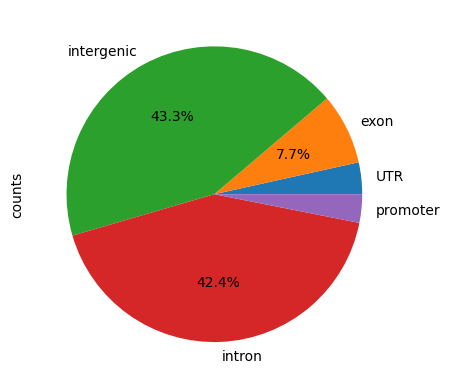

In [23]:
df_cCRE_primary_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

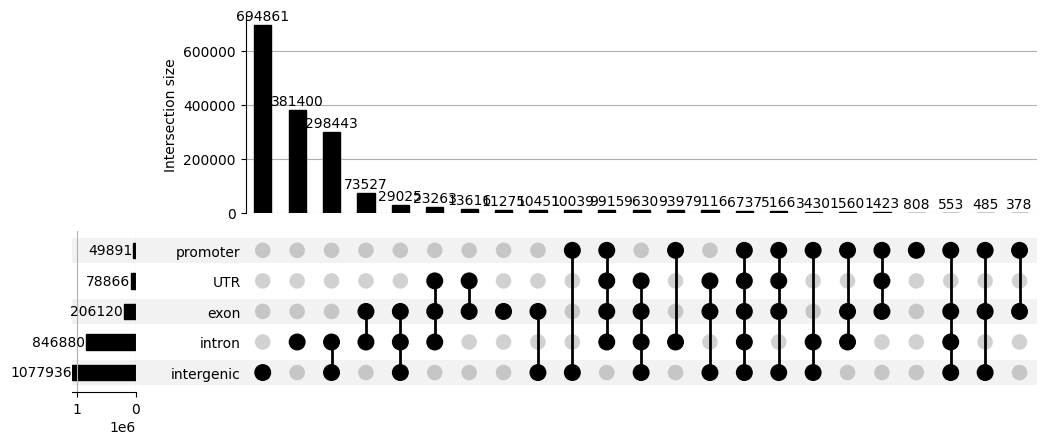

In [24]:
ax_dict = UpSet(cCRE_primary_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [25]:
cCCRE_secondary_gene_regions = {
    # 'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    # 'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    'LINE': set(dict_annot['LINE'].names),
    'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
cCCRE_secondary_gene_regions = from_contents(cCCRE_secondary_gene_regions)

In [26]:
second_priority = [
    "cpg",
    "LTR",
    "LINE",
    "SINE",
    "repeat"
]

<Axes: ylabel='counts'>

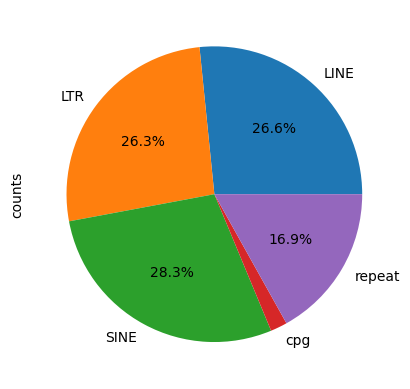

In [27]:
df_cCRE_secondary = cCCRE_secondary_gene_regions.reset_index()
df_cCRE_secondary = get_proity_region(df_cCRE_secondary,priority=second_priority)
df_cCRE_secondary_c = df_cCRE_secondary.groupby(['annotation']).size().reset_index(name='counts')
df_cCRE_secondary_c.set_index('annotation').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

/tmp/ipykernel_1865244/2201135378.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


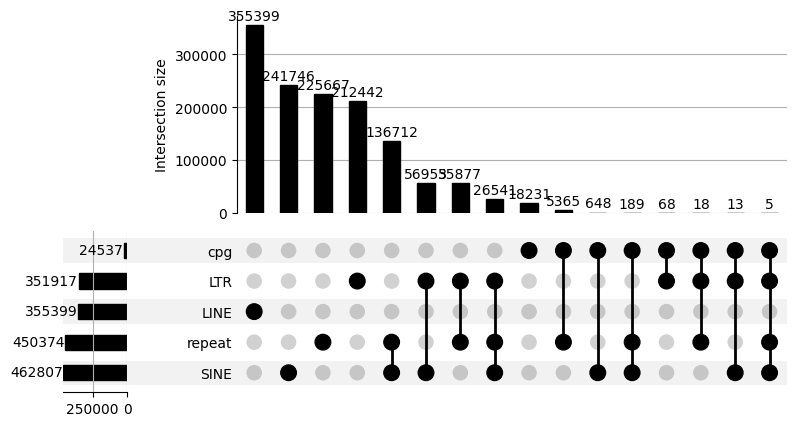

In [28]:
upset = UpSet(cCCRE_secondary_gene_regions, subset_size="count", sort_by="cardinality", show_counts=True)
ax_dict = upset.plot()
# for rect in ax_dict['intersections'].containers:
#     ax_dict['intersections'].bar_label(
#         rect,
#         rotation=45
#     )
# upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality")
# ax_dict2 = upset.plot()

plt.tight_layout()
plt.show()
gene_regions_peaks = cCCRE_secondary_gene_regions

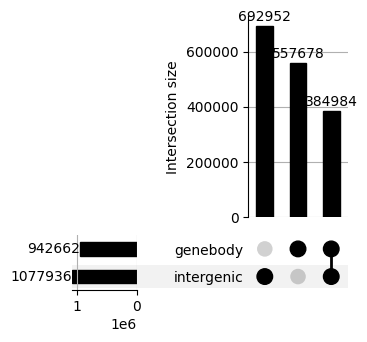

In [29]:
gene_regions = {
    'genebody': set(dict_annot['genebody'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


Calculate the peak proportion in each subtype

In [30]:
# If the peak macs ends
df_allpeaks = pd.read_csv("/data2st1/junyi/output/atac0627/iterative/peaks.csv",index_col=0)
df_allpeaks.set_index('Peaks', inplace=True)
df_nonoverlapping = pd.read_csv("/data2st1/junyi/output/atac0627/cCRE/non_overlapp_rdhs.bed", sep="\t", header=None)    
df_nonoverlapping["names"] = df_nonoverlapping[0] + ":" + df_nonoverlapping[1].astype(str) + "-" + df_nonoverlapping[2].astype(str) 
df_overlapping = pd.read_csv("/data2st1/junyi/output/atac0627/cCRE/overlap_rdhs.bed", sep="\t", header=None)
df_overlapping["names"] = df_overlapping[0] + ":" + df_overlapping[1].astype(str) + "-" + df_overlapping[2].astype(str)
#df_overlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).difference(set(df_allpeaks.index.values)))]
df_unoverlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_overlap = df_allpeaks.loc[list(set(df_overlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_unoverlap_count = df_unoverlap.sum(axis=1).reset_index()
df_overlap_count = df_overlap.sum(axis=1).reset_index()
df_overlap_count["count"] = df_overlap_count[0].clip(0,10)
df_unoverlap_count["count"] = df_unoverlap_count[0].clip(0,10)
cluster_counts = df_overlap_count.groupby("count").size().reset_index(name='counts').counts.values.tolist()
df_ovlap_c = df_overlap_count.groupby("count").size().reset_index(name='counts')
df_unoverlap_c = df_unoverlap_count.groupby("count").size().reset_index(name='counts')

<Axes: ylabel='counts'>

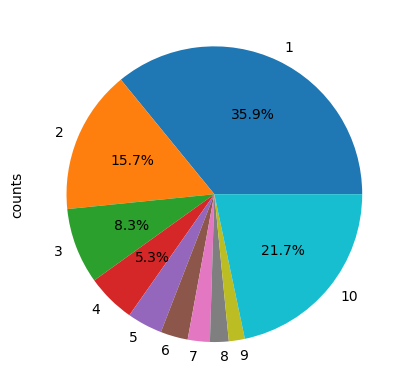

In [31]:
df_unoverlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


<Axes: ylabel='counts'>

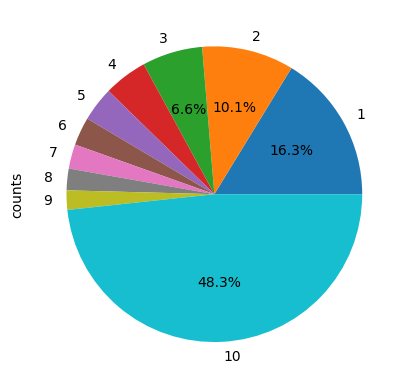

In [32]:
df_ovlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)



 ​Priority Ranking (Highest to Lowest)​​
- ​CpG Islands​
    - Strongly associated with ​gene promoters​ and regulatory regions.
    - Key for ​DNA methylation​ and gene silencing (e.g., tumor suppressor genes).
    - ​Priority rationale:​​ Disruption can directly affect gene expression.
- ​LTR (Long Terminal Repeat) Elements​
    - Often contain ​functional promoters/enhancers​ (e.g., endogenous retroviruses).
    - Can regulate nearby genes (e.g., HERV-H in pluripotency).
    - ​Priority rationale:​​ Regulatory influence comparable to CpG islands.
- ​LINE (Long Interspersed Nuclear Elements)​​
    - Can harbor ​weak promoters​ and affect chromatin structure.
    - Less conserved than LTRs but still functional (e.g., LINE-1 ORF2 encodes reverse transcriptase).
    - ​Priority rationale:​​ Moderate regulatory potential.
- ​SINE (Short Interspersed Nuclear Elements)​​
    - Mostly ​non-autonomous, rely on LINE machinery.
    - Few known regulatory roles (exception: Alu elements in RNA editing).
    - ​Priority rationale:​​ Lowest functional impact unless in a transcribed region.


In [36]:

# 打开 bigWig 文件
bw_pcon = "/data2st1/junyi/phascon/mm10.60way.phastCons.bw"

In [37]:
def cal_pasconscore(input_bed, input_bw):

    bw = pyBigWig.open(input_bw)
    
    scores_list_non = []

    with open(input_bed, "r") as bed_file:
        for line in bed_file:
            line_s = line.strip().split('\t')
            chrom, start, end= line_s[0], line_s[1], line_s[2]
            start = int(start)
            end = int(end)
            summit = (start +
                    end) // 2
            

            # 获取 PhastCons 分数
            try:
                scores = bw.values(chrom, summit -250, summit + 250)
                scores = [score for score in scores if score is not None]
            except:
                continue    
            # 计算平均分数
            # mean_score = np.mean(scores)
            # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
            scores_list_non.append(scores)

    scores_array_non = np.array(scores_list_non)
    scores_array_non = np.nan_to_num(scores_array_non)
    #mean_value_non = np.mean(scores_array_non, axis=0)

    return scores_array_non

In [338]:
df_dar_wil = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [339]:
df_dar_wil.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed",index=False,header=False, sep="\t")

In [38]:
ovlp_rdhs = "/data2st1/junyi/output/atac0627/cCRE/overlap_rdhs.bed"
scores_array = cal_pasconscore(ovlp_rdhs, bw_pcon)
mean_value = np.mean(scores_array, axis=0)

In [41]:
# 
non_ovlp_rdhs = "/data2st1/junyi/output/atac0627/cCRE/non_overlapp_rdhs.bed"
scores_array_non = cal_pasconscore(non_ovlp_rdhs, bw_pcon)
mean_value_non = np.mean(scores_array_non, axis=0)

In [ ]:
# dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
# scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
# mean_value_dar = np.mean(scores_array_dar, axis=0)
# dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
# scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
# mean_value_dar = np.mean(scores_array_dar, axis=0)
# wil_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed"
# scores_array_wil = cal_pasconscore(wil_bed, bw_pcon)
# mean_value_wil = np.mean(scores_array_wil, axis=0)
# memht_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_mementoht.bed"
# scores_array_memht = cal_pasconscore(memht_bed, bw_pcon)
# mean_value_memht = np.mean(scores_array_memht, axis=0)

In [39]:
sns.set_style("whitegrid")


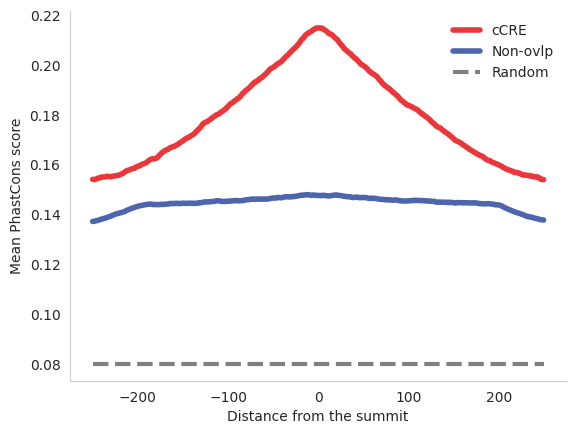

In [42]:
x = np.arange(-250, 250)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(x, mean_value,color='#EB3739', label='cCRE',linewidth=4)
plt.plot(x, mean_value_non, color='#4C65AC', label='Non-ovlp',linewidth=4)
# plt.plot(x, mean_value_dar, color='Orange', label='DAR-mememto',linewidth=4)
# plt.plot(x, mean_value_wil, color='green', label='DAR-wilcoxon',linewidth=4)
# plt.plot(x, mean_value_memht, color='purple', label='DAR-mememtoHT',linewidth=4)
plt.plot(x, np.zeros_like(x)+0.08, color='grey',label='Random', linestyle='--', linewidth=3)
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend(loc='upper right',frameon=False)
plt.grid(visible=False)
plt.axis('tight')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.show()

